In [39]:
using PyPlot
using QuantumOptics
using Statistics, Distributions, Random
using PhysicalConstants.CODATA2018: c_0, k_B, m_u
using Unitful

using DataFrames
using CSV

using DifferentialEquations
using LinearAlgebra

using SplitApplyCombine

In [44]:
include("../src/atom_sampler.jl");
include("../src/lasernoise_sampler.jl");
include("../src/utilities.jl");
include("../src/rydberg_model.jl");
include("../src/ColdAtoms.jl")

using .ColdAtoms

In [4]:
include("../params/default.jl")

2-element Vector{Float64}:
  9.42477796076938
 28.274333882308138

### Atom in dipole trap, choice of constants.

__Potential energy__

$\Pi = U_0 \left(1 - \frac{1}{1+(z/z_0)^2} exp\left(\frac{-2(x^2+y^2)}{w_0^2(1+(z/z_0)^2)}\right) \right)$


__Kinetic energy__

$K = \frac{m V^2}{2}$


__Total energy__

$E = \Pi + K$



__Constants__

$E = \varepsilon E_0, \;\;\; E_0 = 10\mu K$


$kT = t E_0$ 


$V = v v_0, \;\;\; v_0 = \sqrt{\frac{E_0}{m}}$


$R = r r_0, \;\;\; r_0 = 1\mu m$


__Dimensionless units__


$\Pi =  u_0 E_0 \left(1 - \frac{1}{1+(z/z_0)^2} exp\left(\frac{-2(x^2+y^2+z^2)}{w_0^2(1+(z/z_0)^2)}\right) \right)$


$K = E_0\frac{v^2}{2}$


$p(x,y,z,v_x,v_y,v_z) \sim exp\left(- \frac{u_0}{t}\left(1 - \frac{1}{1+(z/z_0)^2} exp\left(\frac{-2(x^2+y^2+z^2)}{w_0^2(1+(z/z_0)^2)}\right) \right) \right)exp\left(- \frac{v_x^2+v_y^2+v_z^2}{2t} \right)$


Markov Chain Monte Carlo is used to generate initial conditions $(x,y,z,v_x,v_y,v_z)|_{t=0}$

__Harmonic approximation__


For $T\ll U_0$ gaussian potential can be replaced with harmonic one.

$U(x,y,z)=U_0\left( \frac{2(x^2+y^2)}{w_0^2} + \frac{z^2}{z_0^2}\right) = 
\frac{m \omega_r ^2 (x^2+y^2)}{2} + \frac{m \omega_z ^2 (z^2)}{2}$, where 

$\omega_r = \sqrt{\frac{4 U_0}{m w_0^2}} = \frac{2}{w_0} \sqrt{\frac{U_0}{E_0}}\sqrt{\frac{E_0}{m}} = 2 \frac{v_0}{w_0}  \sqrt{u_0}$

$\omega_z = \sqrt{\frac{2 U_0}{m z_0^2}} = \sqrt{2}\frac{v_0}{z_0}  \sqrt{u_0}$.


_In that case atom dynamics is integrable:_

$H = \frac{m \omega_r ^2 (x^2+y^2)}{2} + \frac{m \omega_z ^2 (z^2)}{2} + \frac{m(v_x^2+v_y^2+v_z^2)}{2}$

$x(t)=x_0 \cos(\omega_r t) + \frac{v_{x0}}{\omega_r}\sin(\omega_r t)$,

$y(t)=y_0 \cos(\omega_r t) + \frac{v_{y0}}{\omega_r}\sin(\omega_r t)$,

$z(t)=z_0 \cos(\omega_r t) + \frac{v_{z0}}{\omega_z}\sin(\omega_r t)$

$(x_0,y_0,z_0,v_{x0},v_{y0},v_{z0})$ can be sampled using Monte-Carlo

### Atom motion in dipole tweezer as a source of decoherence.

Atom motion in optical tweezer leads to several effects, which cause decoherence of Rydberg two-photon excitation:

- Doppler shifts

- Position-dependent Rabi frequencies

- Position-dependent AC Stark shifts

### Doppler effect in two-level system(TLS). 

Sylvain de Léséleuc, Daniel Barredo, Vincent Lienhard, Antoine Browaeys, and Thierry Lahaye, "Analysis of imperfections in the coherent optical excitation of single atoms to Rydberg states"

![Doppler effect](./images/Browayes_Doppler.png)

In [46]:
N = 2000;
samples, acc_rate = samples_generate(trap_params, atom_params, N; freq=200, skip=2000, harmonic=false);
samples_h, acc_rate_h = samples_generate(trap_params, atom_params, N*20; freq=200, skip=2000, harmonic=true);
ColdAtoms.samples_visualise_rus(samples; samples_harmonic=samples_h, harmonic=true)
gcf()
savefig("/Users/goloshch/Desktop/Materials/QOTLabs/Деловое/Отчет_23/images/mcmc.svg")
savefig("/Users/goloshch/Desktop/Materials/QOTLabs/Деловое/Отчет_23/images/mcmc.pdf")
savefig("/Users/goloshch/Desktop/Materials/QOTLabs/Деловое/Отчет_23/images/mcmc.png")

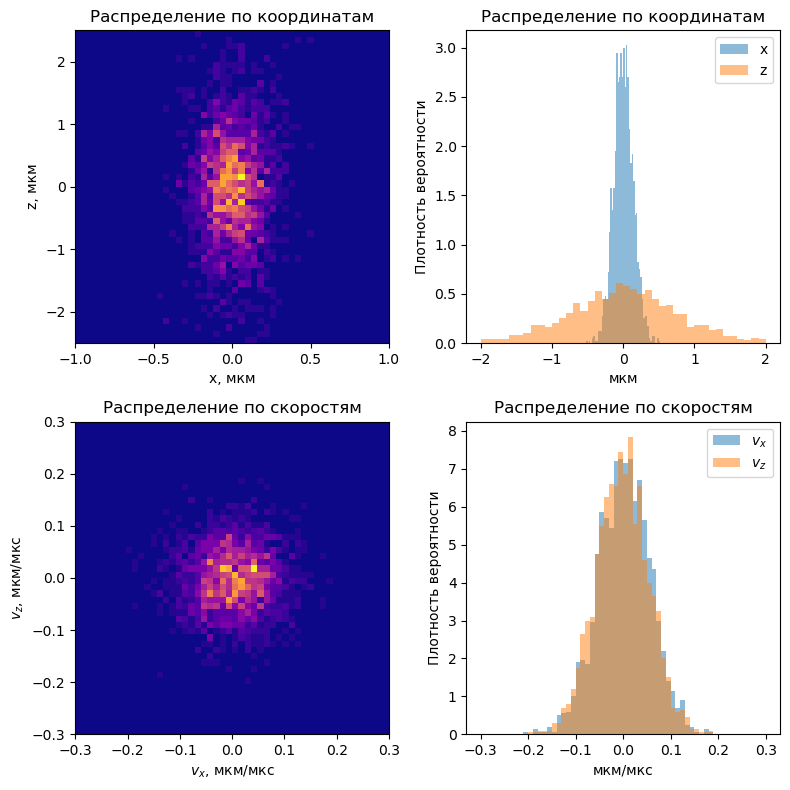

In [47]:
ColdAtoms.samples_visualise_rus(samples)

gcf()

In [9]:
tspan = (0.0, 10.0);
basis = NLevelBasis(4);
ψ0 = nlevelstate(basis, 1);

λ_r = 0.795;
λ_b = 0.420;
w0_r = 5.0;
w0_b = 5.0;
z0_r = w0_to_z0(w0_r, λ_r);
z0_b = w0_to_z0(w0_b, λ_b);

red_laser_params = [2π * 14.0, w0_r, z0_r];
blue_laser_params = [2π * 14.0, w0_b, z0_b];
detuning_params = [2*π * 740.0, 0.0];
tspan = [0.0:1.0:15.0;];


# simulation_schroedinger(
#     tspan, ψ0, 

#     red_laser_params,
#     blue_laser_params,
#     detuning_params,

#     samples,

#     [],
#     [],
#     [],

#     laser_noise=false,
#     atom_dynamics=true
#     )

16-element Vector{Float64}:
  0.0
  1.0
  2.0
  3.0
  4.0
  5.0
  6.0
  7.0
  8.0
  9.0
 10.0
 11.0
 12.0
 13.0
 14.0
 15.0

In [19]:
ρ_mean = simulation_schroedinger(
    tspan, ψ0, 
    trap_params,
    atom_params,

    red_laser_params,
    blue_laser_params,
    detuning_params,
    
    samples,
    
    [],
    [],
    [],
)

UndefVarError: UndefVarError: t not defined

### Finite contrast, Browayes.

- if I measure recapture probability $p_{recap}$ from switch-off time $\tau$, I can retrieve dsitribution of atoms over velocities. It seems like $\frac{d}{d\tau}p_{recap}(\tau)$ should give some insight about it.


- $\varepsilon ' \simeq \Gamma_R t_{recap}$, where $t_{recap}=\int_{0}^{\infty} p_{recap}(t)dt$, $\Gamma_R $ - Rydberg lifetime



- recapture probability is modeled using Monte-Carlo modelling with free-flight regime, anti-trapping